Here the goal is to provide an illustrative example with synthetic data
showing the effect of increasing number of training points on epistemic uncertainty 

In [10]:
import numpy as np
import os 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
import src.helper as h
from src.model import dirichlet_nll_loss_with_regularization, predictor
from src.plots import plot_interval, my_ternery
import tensorflow as tf
from scipy.stats import entropy, wasserstein_distance
import pickle
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
tfd = tfp.distributions

# Generate synthetic data
K = 3 number of classes (for visualization of credal sets)
d = 10 number of features
n = 1000 number of data points for each training, calibration, and test phases 

In [2]:
exp_seed = 200
os.environ['PYTHONHASHSEED']=str(exp_seed)
np.random.seed(exp_seed)

num_data_per_phase = 1000
n = 3*num_data_per_phase 
num_classes = 3
num_features = 10

X = np.random.normal(loc=0.0, scale=1.0, size=(n,num_features)) #random feature vecotrs 
beta = np.random.normal(loc=0.0, scale=1.0, size=(num_features,num_classes)) #random coefficient vector
Z = np.exp(np.matmul(X,beta)) 
W = Z/Z.sum(axis=1)[:,None]

Histogram of the entropy of the generated data

(0.0, 1.0)

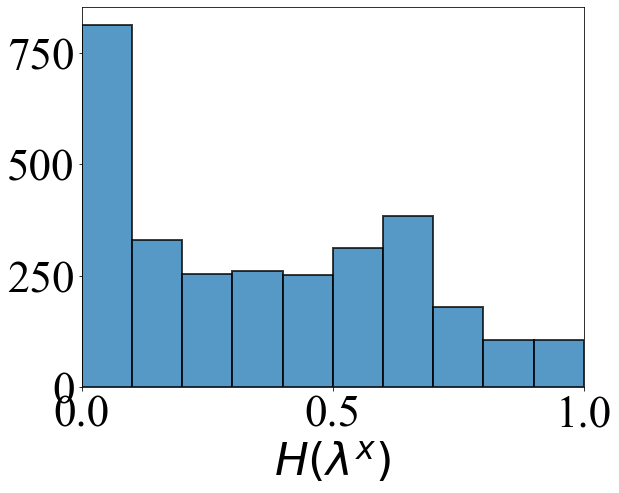

In [3]:
fig = plt.figure(figsize=(9,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
plt.hist(entropy(W, axis=1, base=3), alpha=.75, edgecolor='k', linewidth=2)
plt.xlabel(r'$H(\lambda^x)$')
# plt.title("GT distributions")
plt.xlim([0,1])
# plt.savefig(os.path.join("figures", "chaosNLI", "general", "histogram.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

simplex

In [4]:
simplex_res = 0.005
simplex = np.load(os.path.join("data", "simplex", str(simplex_res)+".npy"))
simplex_ent = entropy(simplex, axis=1, base=3)

Model training and calibration

In [5]:
alpha = 0.1

In [6]:
X_train, X_test, lambda_train, lambda_test = train_test_split(X, W, test_size=num_data_per_phase, random_state=2024+exp_seed)
X_proper_train, X_calib, lambda_proper_train, lambda_calib = train_test_split(X_train, lambda_train, test_size=1000, random_state=2024+exp_seed)

let's find three interesting cases in test data
1. almost uniform distribution 
2. almost dirac distribution
3. almost uniform between two classes

In [24]:
np.argmax(entropy(lambda_test, axis=1, base=3))

397

In [25]:
lambda_test[397]

array([0.3150294, 0.3336913, 0.3512793])

In [26]:
np.argmin(entropy(lambda_test, axis=1, base=3))

400

In [27]:
lambda_test[400]

array([9.99998867e-01, 1.13020756e-06, 2.78519277e-09])

In [23]:
np.where((entropy(lambda_test, axis=1, base=3) <0.64) & (entropy(lambda_test, axis=1, base=3) >0.63))

(array([ 86, 145, 204, 233, 276, 317, 356, 377, 469, 546, 593, 601, 716,
        782, 802, 851, 885, 997], dtype=int64),)

In [41]:
lambda_test[204]

array([0.00063194, 0.51751339, 0.48185467])

# Constructing the sets for all methods and all test points

In [7]:
predictor_order = "first"
idx_list_dic = {}
lambda_hat_test_dic = {}
for train_data in [10, 50, 100, 500, 1000]: 
    print(train_data)

    model = predictor(order=predictor_order, feature_dim=num_features)
    if predictor_order == "first": 
        loss_fn = tf.keras.losses.CategoricalCrossentropy()
    else: 
        loss_fn = dirichlet_nll_loss_with_regularization
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn)

    model.fit(X_proper_train[:train_data], lambda_proper_train[:train_data], epochs=100, batch_size=8, shuffle=False, verbose=0)
    if predictor_order == "first": 
        lambda_hat_calib = model.predict(X_calib)
        lambda_hat_test = model.predict(X_test)
        distance_functions = ["tv", "kl", "ws", "inner"]
        calib_scores = {k: [] for k in distance_functions}
        for i in range(lambda_hat_calib.shape[0]):
            calib_scores["tv"].append(h.tv(lambda_hat_calib[i], lambda_calib[i]))
            calib_scores["kl"].append(entropy(lambda_calib[i], lambda_hat_calib[i], base=2))
            calib_scores["ws"].append(wasserstein_distance([0,1,2], [0,1,2], lambda_hat_calib[i], lambda_calib[i]))
            calib_scores["inner"].append(1-np.inner(lambda_hat_calib[i], lambda_calib[i]))
    q = {}
    for d in calib_scores.keys():
        q[d] = h.compute_quantile(calib_scores[d], alpha)
    print(q["tv"])
    # idx_list = []
    # for k in range(lambda_hat_test.shape[0]):
    #     p = lambda_test[k]
    #     ph = lambda_hat_test[k]
        
    #     idx = {}
    #     idx["tv"] = np.where((0.5*np.sum(np.abs(ph-simplex), axis=1))< q["tv"])[0]
    #     idx["kl"] = np.where(entropy(simplex, ph, base=2, axis=1)< q["kl"])[0]
    #     idx["inner"] = np.where((1-np.inner(ph, simplex))< q["inner"])[0]
    #     idx_ws = []
    #     for i in range(simplex.shape[0]):
    #         if wasserstein_distance(np.arange(3), np.arange(3), ph, simplex[i]) < q["ws"]:
    #             idx_ws.append(i)   
    #     idx["ws"] = idx_ws
    #     idx_list.append(idx)
    # idx_list_dic[train_data] = idx_list
    lambda_hat_test_dic[train_data] = lambda_hat_test

10


32/32 [==============================] - 0s 739us/step
0.6711507839643548
50
32/32 [==============================] - 0s 717us/step
0.34916221762010574
100
32/32 [==============================] - 0s 707us/step
0.17155995810091337
500
32/32 [==============================] - 0s 707us/step
0.04775948436711194
1000
32/32 [==============================] - 0s 740us/step
0.050579044300035875


In [12]:
# os.makedirs(os.path.join("results", "synthetic_illustrative", "seed_"+str(exp_seed)), exist_ok=True)  
# with open(os.path.join("results", "synthetic_illustrative", "seed_"+str(exp_seed), "all_credal_sets.pkl"), 'wb') as f:
#     pickle.dump(idx_list_dic, f)

In [8]:
with open(os.path.join("results", "synthetic_illustrative", "seed_"+str(exp_seed), "all_credal_sets.pkl"), 'rb') as f:
        idx_list_dic = pickle.load(f)

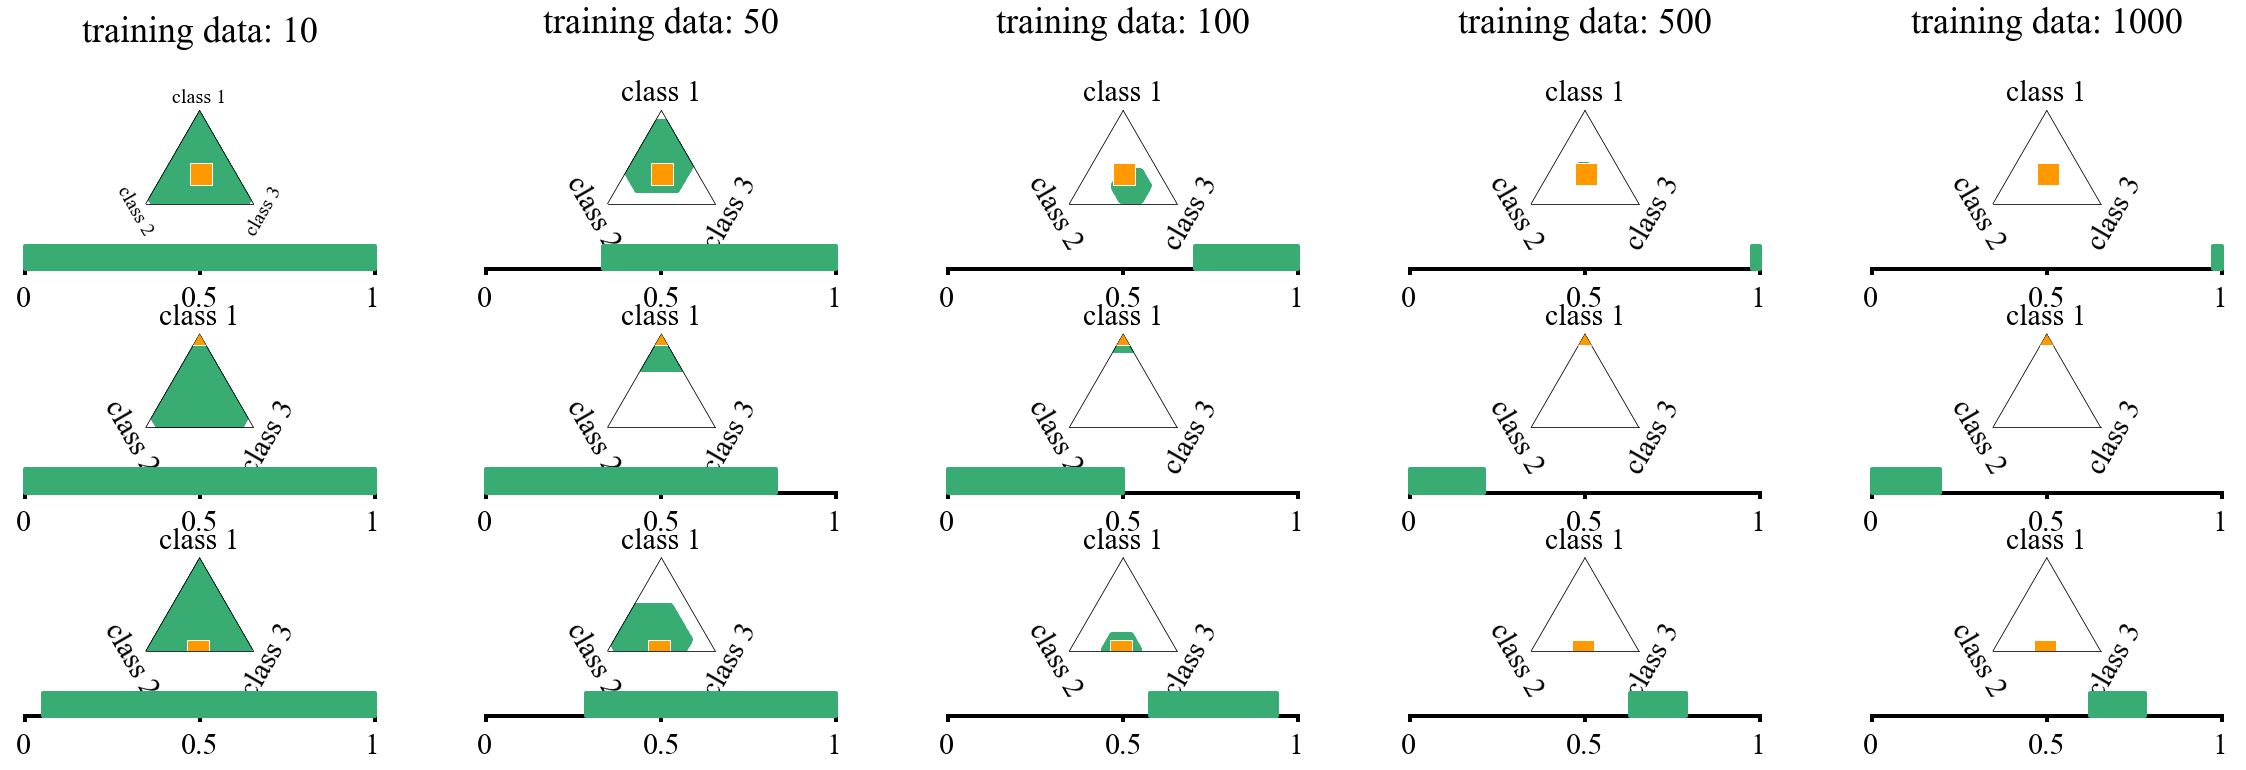

In [11]:
fig= plt.figure(figsize=(40, 12))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
for i, k in enumerate([397, 400, 204]):
    p = lambda_test[k]
    for j, train_data in enumerate([10, 50, 100, 500, 1000]):
        ax = fig.add_subplot(6, 5, 10*i + j+1, projection='ternary')
        my_ternery(ax=ax, credal_set=simplex[idx_list_dic[train_data][k]["tv"]], p=p, labels=["class 1", "class 2", "class 3"])
        ax2 = fig.add_subplot(6, 5, 5+ 10*i + j+1)
        plot_interval(np.min(simplex_ent[idx_list_dic[train_data][k]["tv"]]), np.max(simplex_ent[idx_list_dic[train_data][k]["tv"]]), ax=ax2)
        if i==0:
            ax.set_title("training data: "+str(train_data)+"\n")
# os.makedirs(os.path.join("figures", "synthetic_showcase", "seed_"+str(exp_seed)), exist_ok=True) 
# plt.savefig(os.path.join("figures", "synthetic_showcase", "seed_"+str(exp_seed), "alpha_"+str(alpha)+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

In [50]:
len(idx_list_dic[train_data])

1000

In [15]:
methods = list(idx_list_dic[train_data][0].keys())
TU_dic = {}
AU_dic = {}
EU_dic = {}
for j, train_data in enumerate([10, 50, 100, 500, 1000]):
    TU = {m: [] for m in methods}
    AU = {m: [] for m in methods}
    EU = {m: [] for m in methods}
    for i,p in enumerate(lambda_hat_test):
        for m in  methods:
            if len(idx_list_dic[train_data][i][m]):
                tu, au, eu = h.tu_au_eu(simplex_ent[idx_list_dic[train_data][i][m]])
            else:
                tu, au, eu = np.nan, np.nan, np.nan
            TU[m].append(tu)
            AU[m].append(au)
            EU[m].append(eu)
    TU_dic[train_data] = TU
    AU_dic[train_data] = AU
    EU_dic[train_data] = EU

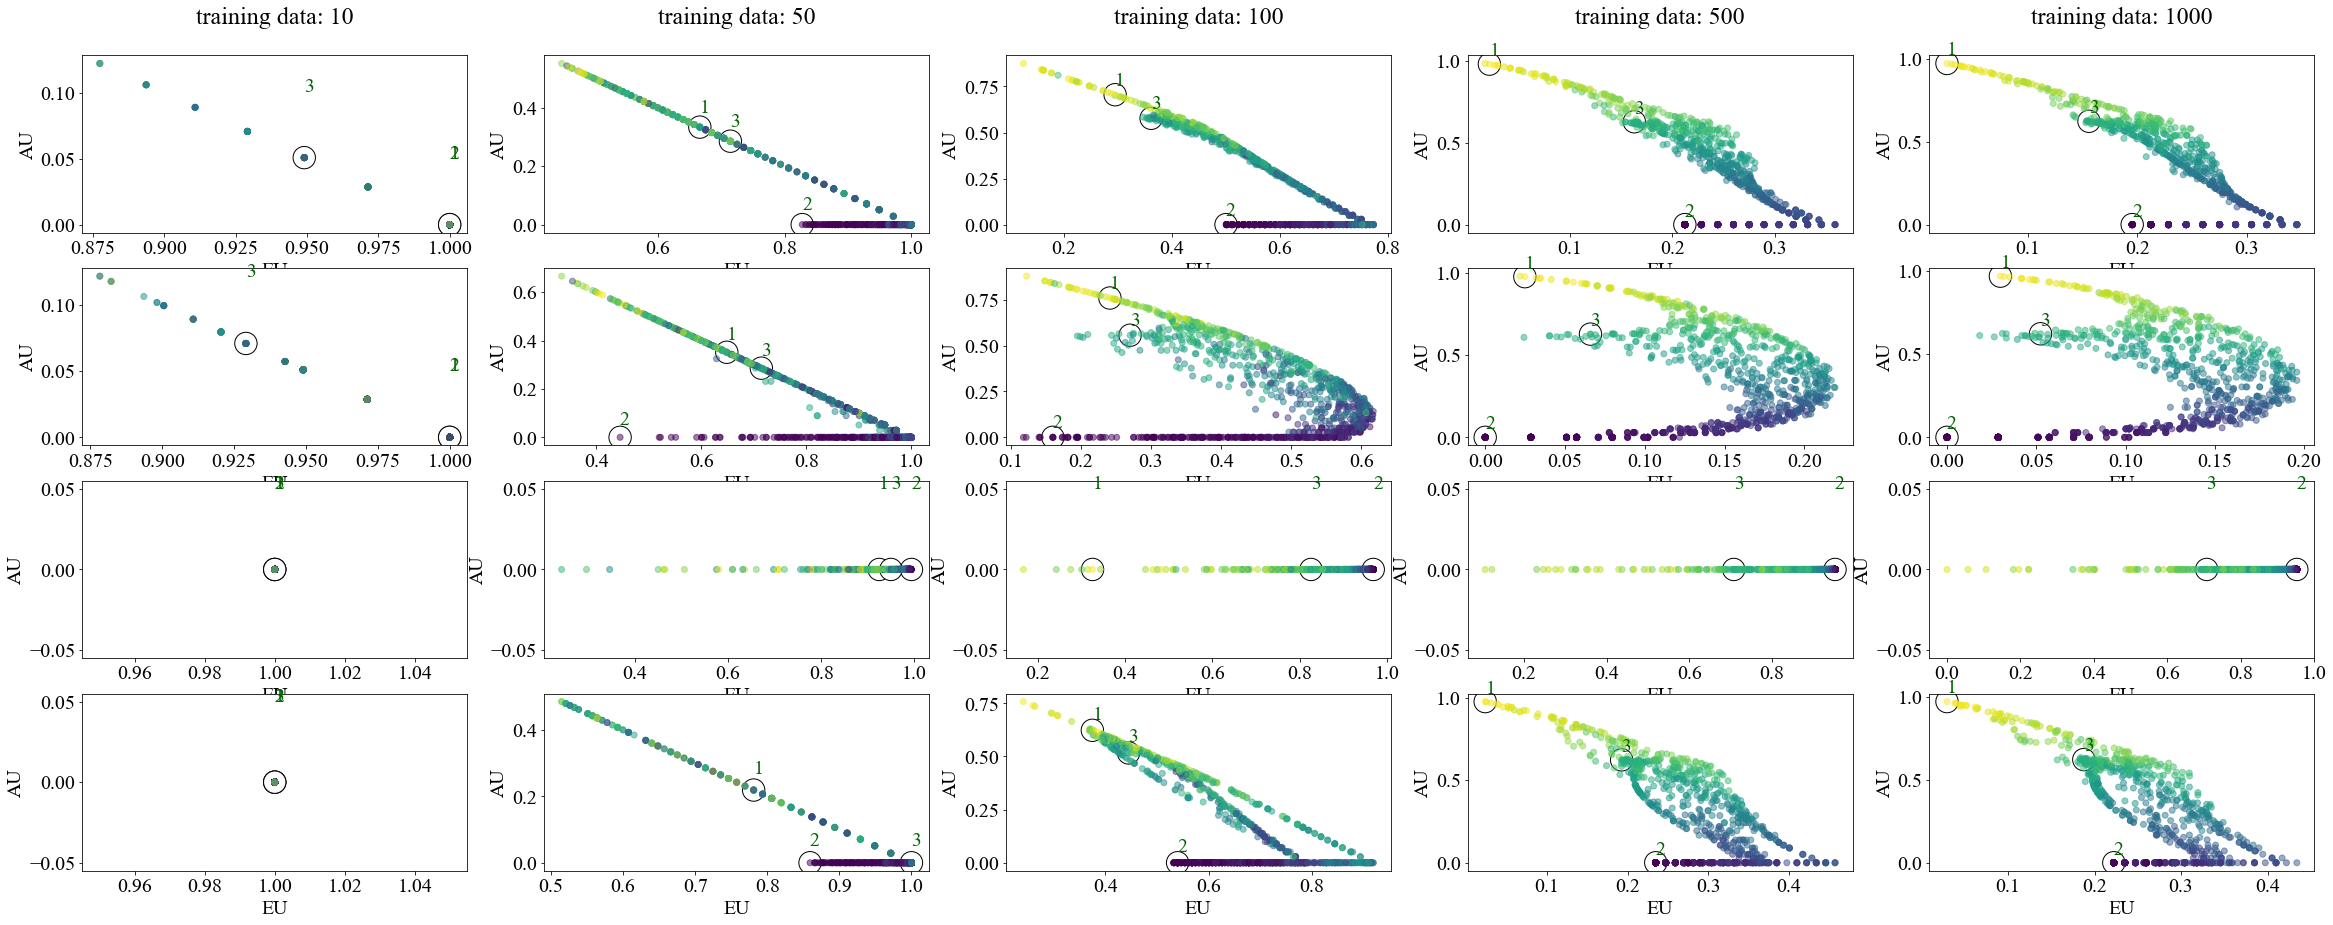

In [16]:
fig= plt.figure(figsize=(40, 15))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
for i, m in enumerate(list(methods)):
    for j, train_data in enumerate([10, 50, 100, 500, 1000]):
        ax = fig.add_subplot(4, 5, 5*i + j+1)
        ax.scatter(np.array(EU_dic[train_data][m]), np.array(AU_dic[train_data][m]), alpha=0.5, c=entropy(lambda_test, axis=1, base=3), cmap='viridis', vmax=1, zorder=3)
        ax.scatter(np.array(EU_dic[train_data][m])[[397, 400, 204]], np.array(AU_dic[train_data][m])[[397, 400, 204]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
        for jj, j in enumerate([397, 400, 204]):
            ax.annotate(jj+1, (EU_dic[train_data][m][j],0.05+AU_dic[train_data][m][j]), c="darkgreen")

        ax.set_xlabel("EU")
        ax.set_ylabel("AU")
        if i==0:
            ax.set_title("training data: "+str(train_data)+"\n")

In [64]:
for train_data in [10, 50, 100, 500, 1000]:
    for i, m in enumerate(list(methods)):
        fig = plt.figure(figsize=(7,7)) 
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 45
        # plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
        sc = plt.scatter(np.array(EU_dic[train_data][m]), np.array(AU_dic[train_data][m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=entropy(lambda_test, axis=1, base=3), cmap='viridis', vmax=1, s=200, zorder=3)
        # plt.scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['gold']*3, marker="*", s=300,edgecolor='black', linewidth = 0.5)
        sc2 = plt.scatter(np.array(EU_dic[train_data][m])[[397, 400, 204]], np.array(AU_dic[train_data][m])[[397, 400, 204]],  marker="o", s=800,edgecolor='k', linewidth = 1, zorder=3)
        sc2.set_facecolor("none")
        for jj, j in enumerate([397, 400, 204]):
            plt.annotate(jj+1, (EU_dic[train_data][m][j]-0.025,0.05+AU_dic[train_data][m][j]), c="k")
        plt.xlabel("EU")
        plt.ylabel("AU")
        plt.xticks([0, 0.5, 1])

    # Set y-axis tick values
        plt.yticks([0, 0.5, 1])
        plt.xlim([0,1.1])
        plt.ylim([-.10,1])
        os.makedirs(os.path.join("figures", "synthetic_illustrative", "uncertainty", "seed_"+str(exp_seed), "num_train_"+str(train_data), "AU_EU"), exist_ok=True)  
        plt.savefig(os.path.join("figures", "synthetic_illustrative", "uncertainty", "seed_"+str(exp_seed), "num_train_"+str(train_data), "AU_EU", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        plt.close()


In [34]:
m = "kl"
for k in [397, 400, 204]:
    for train_data in [10, 50, 100, 500, 1000]:
        plt.figure(figsize=(10,10))
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 70
        ax = plt.subplot(projection="ternary")
        my_ternery(credal_set=simplex[idx_list_dic[train_data][k][m]], ax=ax, p=lambda_test[k], ph=lambda_hat_test_dic[train_data][k], alpha=None, labels=["class 1", "class 2", "class 3"])
        os.makedirs(os.path.join("figures", "synthetic_illustrative", "seed_"+str(exp_seed)+"_K_"+str(k), "num_train_"+str(train_data)), exist_ok=True)  
        plt.savefig(os.path.join("figures", "synthetic_illustrative", "seed_"+str(exp_seed)+"_K_"+str(k), "num_train_"+str(train_data),  m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        plt.close()
        plot_interval(np.min(simplex_ent[idx_list_dic[train_data][k][m]]), np.max(simplex_ent[idx_list_dic[train_data][k][m]]))
        plt.savefig(os.path.join("figures", "synthetic_illustrative", "seed_"+str(exp_seed)+"_K_"+str(k), "num_train_"+str(train_data), m+"_unc_interval.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        plt.close()


In [18]:
lambda_test[400]

array([9.99998867e-01, 1.13020756e-06, 2.78519277e-09])

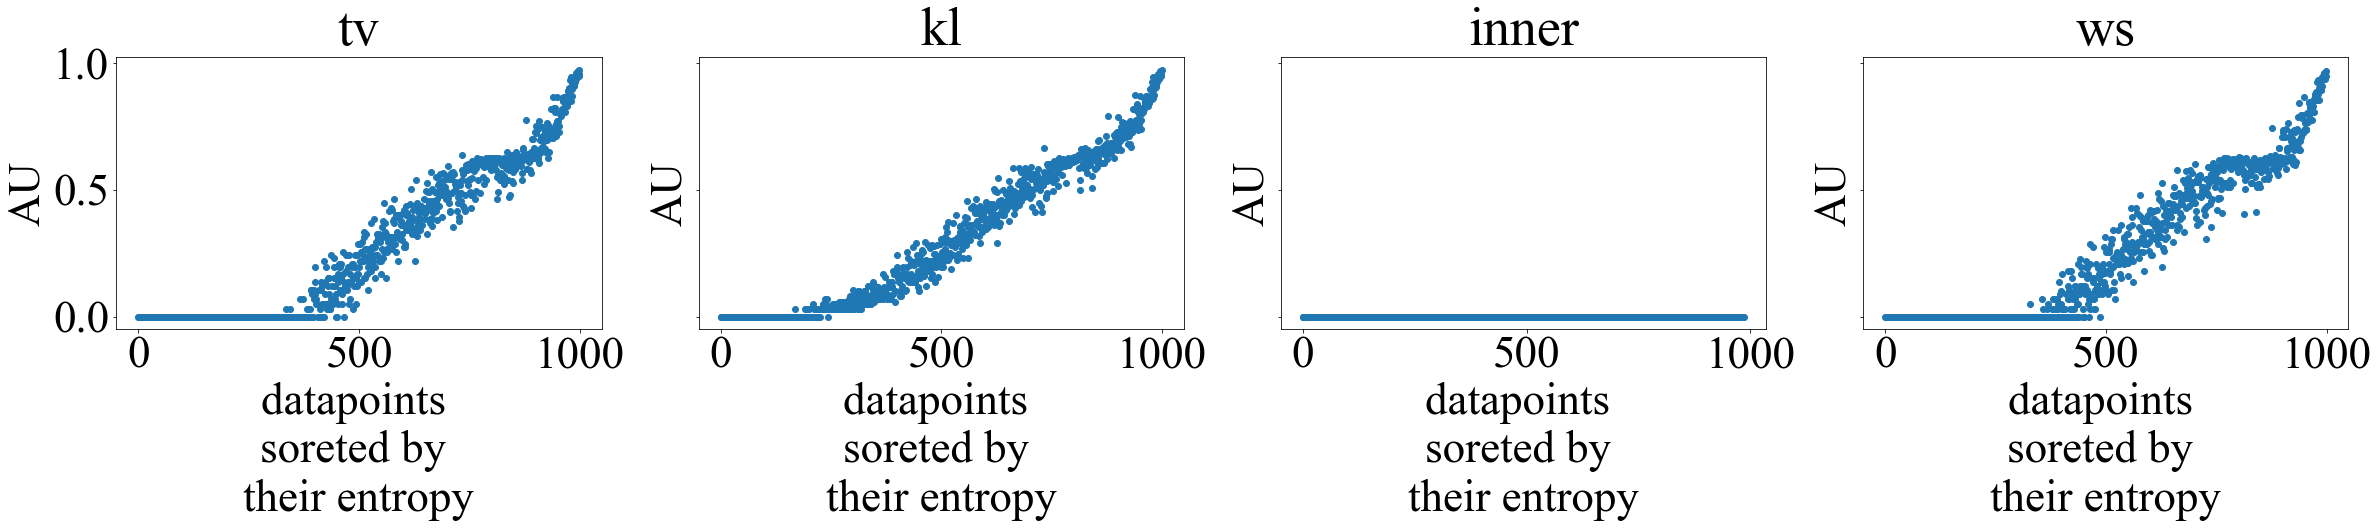

In [15]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(np.arange(len(lambda_test)), np.array(AU_dic[1000][m])[np.argsort(entropy(lambda_test, base=10, axis=1))])
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    # for jj, j in enumerate([583, 302, 307]):
    #     axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("datapoints \nsoreted by \ntheir entropy")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)

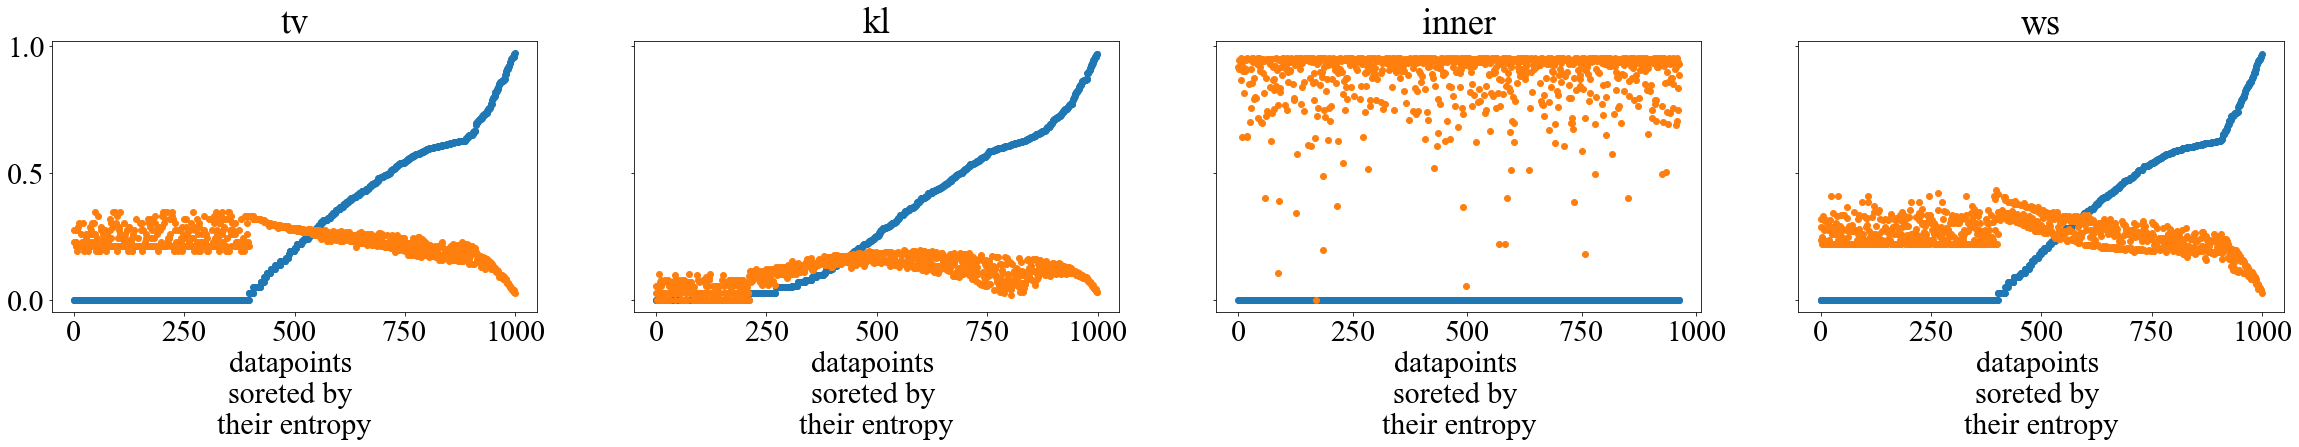

In [23]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(np.arange(len(lambda_test)), np.array(AU_dic[1000][m])[np.argsort(AU_dic[1000][m])])
    axs[i].scatter(np.arange(len(lambda_test)), np.array(EU_dic[1000][m])[np.argsort(AU_dic[1000][m])])
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    # for jj, j in enumerate([583, 302, 307]):
    #     axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("datapoints \nsoreted by \ntheir entropy")
    # axs[i].set_ylabel("AU")
    axs[i].set_title(m)